In [41]:
# This cell checks if the required libraries are installed and installs them if they are not
import sys
import subprocess
import pkg_resources

required = {'yfinance', 'pandas', 'seaborn', 'matplotlib', 'pycaret', 'prophet',}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
!pip install pycaret -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 7.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: pycaret
    Found existing installation: pycaret 3.3.1
    Uninstalling pycaret-3.3.1:
      Successfully uninstalled pycaret-3.3.1


In [42]:
# Part 1: Import Libraries
import datetime as dt
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from pycaret.regression import *
from tabulate import tabulate

In [43]:
# Part 2: Import Tickers
symbols_list = ["DC=F"]
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2024, 4, 1)


In [44]:
# Part 3: Check Data
try:
    data = yf.download(symbols_list, start=start, end=end)
    print("Initial data check:")
    print(data.head())
except Exception as e:
    print("Failed to download data:", e)
    

[*********************100%%**********************]  1 of 1 completed

Initial data check:
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2020-01-02  19.370001  19.370001  19.370001  19.370001  19.370001     464
2020-01-03  17.110001  17.150000  16.870001  16.930000  16.930000     479
2020-01-06  16.950001  17.000000  16.900000  16.969999  16.969999     299
2020-01-07  17.020000  17.139999  17.000000  17.100000  17.100000     261
2020-01-08  17.139999  17.150000  16.940001  17.000000  17.000000     343


In [45]:
# Part 4: Prepare Data

# Inspect the data to see the available columns
print(data.columns)

# Adjust this line to match the exact column name for the adjusted close prices
# If the column name is different, update it accordingly
adjusted_close = data['Adj Close']  # Make sure this matches the actual column name

# Calculate daily returns
returns = adjusted_close.pct_change()
print(returns.head)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
<bound method NDFrame.head of Date
2020-01-02         NaN
2020-01-03   -0.125968
2020-01-06    0.002363
2020-01-07    0.007661
2020-01-08   -0.005848
                ...   
2024-03-22    0.000000
2024-03-25    0.000609
2024-03-26   -0.000609
2024-03-27    0.000000
2024-03-28   -0.004266
Name: Adj Close, Length: 1064, dtype: float64>


Columns in data DataFrame:
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Iron_Lag1', 'Iron_Lag2', 'Iron_Lag3'],
      dtype='object')
First few rows of data DataFrame:
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2020-01-09  16.959999  16.980000  16.910000  16.950001  16.950001     186   
2020-01-10  16.910000  17.040001  16.860001  17.030001  17.030001     254   
2020-01-13  17.020000  17.020000  16.920000  17.010000  17.010000     109   
2020-01-14  16.990000  17.010000  16.910000  16.940001  16.940001     139   
2020-01-15  16.950001  17.000000  16.950001  16.990000  16.990000     138   

             Returns  Iron_Lag1  Iron_Lag2  Iron_Lag3  
Date                                                   
2020-01-09 -0.002941  -0.005848   0.007661   0.002363  
2020-01-10  0.004720  -0.002941  -0.005848   0.007661  
2020-01-13 -0.001174   0.004720  

,Description,Value
0,Session id,123
1,Target,Returns
2,Target type,Regression
3,Original data shape,"(1056, 10)"
4,Transformed data shape,"(1056, 2)"
5,Transformed train set shape,"(739, 2)"
6,Transformed test set shape,"(317, 2)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0065,0.0006,0.0221,-0.0024,0.0202,1.0077,0.1340
en,Elastic Net,0.0065,0.0006,0.0221,-0.0035,0.0202,0.9996,0.0620
llar,Lasso Least Angle Regression,0.0065,0.0006,0.0221,-0.0035,0.0202,0.9996,0.0680
lasso,Lasso Regression,0.0065,0.0006,0.0221,-0.0035,0.0202,0.9996,0.8200
lar,Least Angle Regression,0.0066,0.0006,0.0221,-0.0064,0.0201,1.0273,0.0860
omp,Orthogonal Matching Pursuit,0.0066,0.0006,0.0221,-0.0064,0.0201,1.0273,0.0800
br,Bayesian Ridge,0.0066,0.0006,0.0221,-0.0064,0.0201,1.0273,0.0680
ridge,Ridge Regression,0.0066,0.0006,0.0221,-0.0064,0.0201,1.0273,0.0740
lr,Linear Regression,0.0066,0.0006,0.0221,-0.0064,0.0201,1.0273,1.7760
lightgbm,Light Gradient Boosting Machine,0.0082,0.0007,0.0242,-0.3123,0.0202,2.1050,0.5680


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

Best model selected:
HuberRegressor()


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0081,0.0011,0.0329,-0.0019,0.0295,1.0005
1,0.0097,0.0006,0.0245,-0.0014,0.0234,0.9991
2,0.0124,0.0014,0.0377,-0.0126,0.0345,0.9745
3,0.0054,0.0002,0.0145,-0.0042,0.0139,1.0049
4,0.0037,0.0002,0.0123,-0.0102,0.0118,0.9946
5,0.0041,0.0001,0.0095,-0.0194,0.0093,1.0017
6,0.0032,0.0000,0.0053,-0.0354,0.0053,1.0129
7,0.0052,0.0002,0.0156,-0.0090,0.0149,1.0582
8,0.0027,0.0000,0.0048,-0.0151,0.0048,1.0140


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


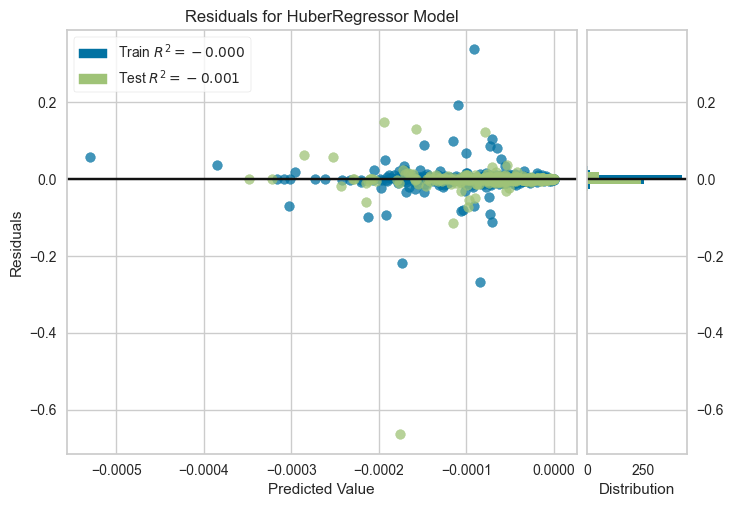

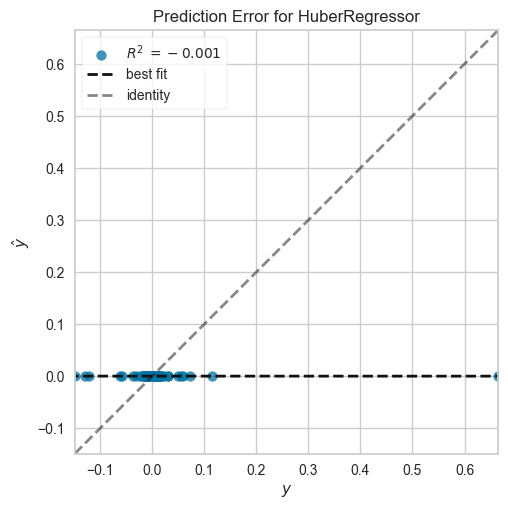

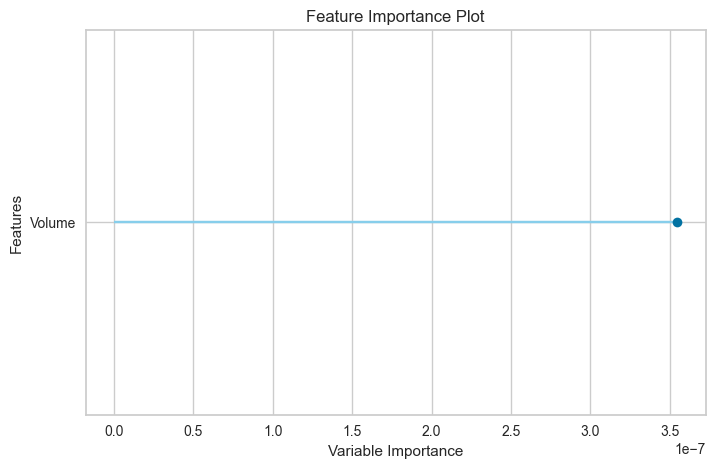

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,0.0083,0.0017,0.0414,-0.0014,0.0332,0.9906


Predictions on the test set:
                 Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2020-09-08  17.000000  17.270000  16.799999  16.850000  16.850000     279   
2023-08-28  17.209999  17.209999  17.190001  17.200001  17.200001       8   
2023-07-20  13.750000  13.800000  13.750000  13.770000  13.770000     250   
2021-07-26  16.549999  16.559999  16.530001  16.530001  16.530001      34   
2023-12-05  16.170000  16.330000  16.160000  16.320000  16.320000     603   
...               ...        ...        ...        ...        ...     ...   
2021-06-03  18.959999  18.959999  18.959999  18.959999  18.959999     251   
2020-02-21  17.020000  17.040001  17.000000  17.010000  17.010000     244   
2021-11-04  18.129999  18.200001  17.820000  17.900000  17.900000     279   
2020-02-05  17.049999  17.049999  17.049999  17.049999  17.049999     231   
2022-05-12  24.990000  25.040001  24.920000  24

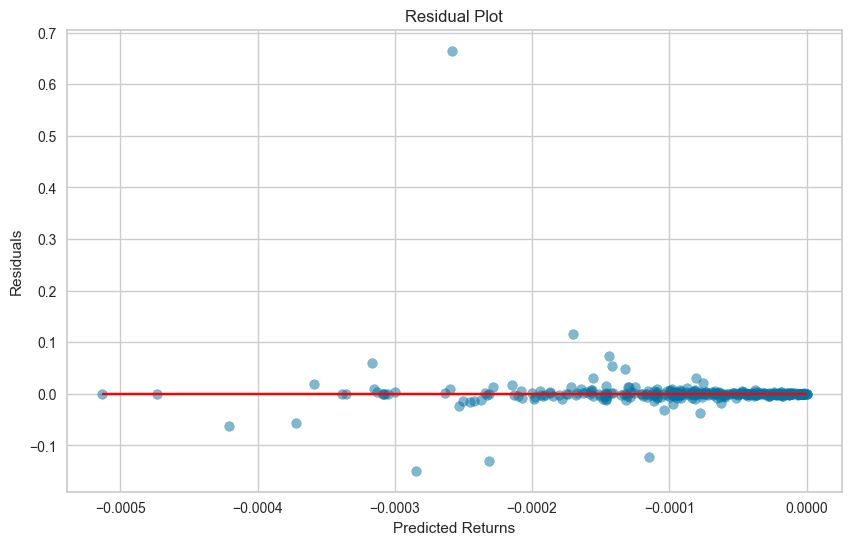

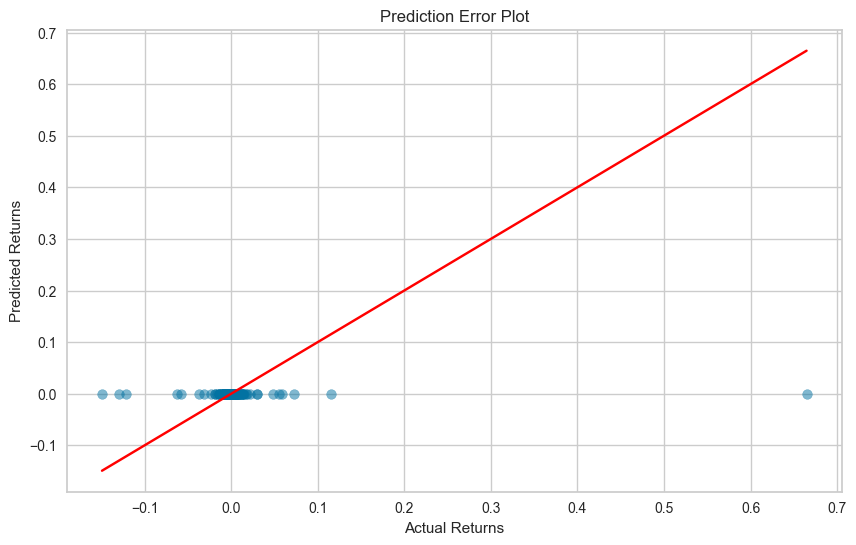

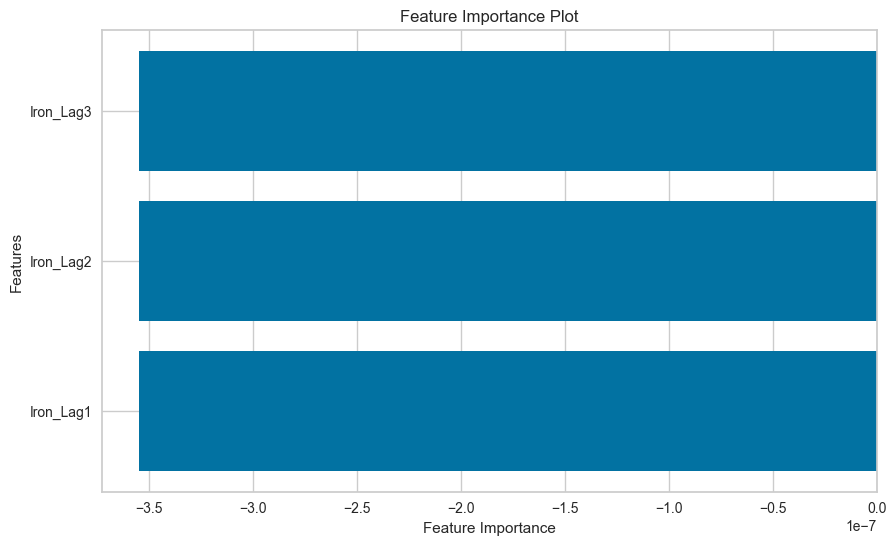

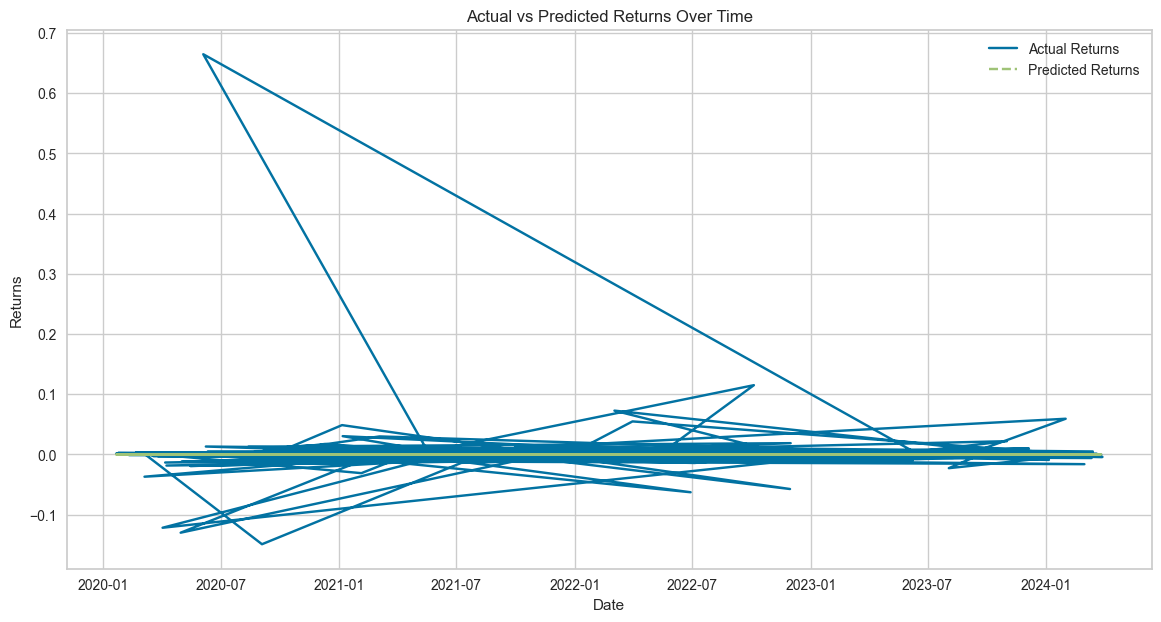

In [54]:
# Part 7: Optimize and Compare Models with PyCaret

# Assuming 'data' is your original DataFrame with 'Adj Close' prices
# Calculate returns
data['Returns'] = data['Adj Close'].pct_change()

# Drop the first row with NaN return
data = data.dropna()

# Ensure the data is loaded correctly and inspect the structure
if isinstance(data, pd.Series):
    data = data.to_frame()

print("Columns in data DataFrame:")
print(data.columns)
print("First few rows of data DataFrame:")
print(data.head())

# Add lagged features to the returns DataFrame, assuming 'Returns' is a numeric column
if 'Returns' in data.columns:
    data['Iron_Lag1'] = data['Returns'].shift(1)
    data['Iron_Lag2'] = data['Returns'].shift(2)
    data['Iron_Lag3'] = data['Returns'].shift(3)

    # Drop rows with NaN values after creating lagged features
    data = data.dropna()

    # Features and target setup
    features = ['Iron_Lag1', 'Iron_Lag2', 'Iron_Lag3']
    target = 'Returns'

    print("Columns in data DataFrame after adding lagged features:")
    print(data.columns)
    print("First few rows of data DataFrame after adding lagged features:")
    print(data.head())

    # Setup the PyCaret environment for 'Returns'
    exp_dc = setup(data=data, 
                   target=target, 
                   session_id=123, 
                   preprocess=True, 
                   numeric_features=features,
                   categorical_features=None, 
                   date_features=None, 
                   text_features=None, 
                   feature_selection=True)

    # Compare a wider range of models to find the best one for 'Returns'
    best_model_dc = compare_models(exclude=['dummy'], fold=5)
    
    # Print the best model to ensure it's not a simple model
    print("Best model selected:")
    print(best_model_dc)
    
    if best_model_dc:
        # Tune the best model
        tuned_model_dc = tune_model(best_model_dc)

        # Plot the results of the tuned model
        plot_model(tuned_model_dc, plot='residuals')
        plot_model(tuned_model_dc, plot='error')
        plot_model(tuned_model_dc, plot='feature')

        # Finalize the model
        final_model_dc = finalize_model(tuned_model_dc)

        # Predict on the test set
        predictions = predict_model(final_model_dc)

        # Evaluate performance
        print("Predictions on the test set:")
        print(predictions)

        # Extract actual and predicted returns
        actual_returns = predictions['Returns']
        predicted_returns = predictions['prediction_label']
        dates = predictions.index

        # Residual Plot
        residuals = actual_returns - predicted_returns
        plt.figure(figsize=(10, 6))
        plt.scatter(predicted_returns, residuals, alpha=0.5)
        plt.hlines(y=0, xmin=min(predicted_returns), xmax=max(predicted_returns), colors='red')
        plt.xlabel('Predicted Returns')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.show()

        # Prediction Error Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(actual_returns, predicted_returns, alpha=0.5)
        plt.plot([min(actual_returns), max(actual_returns)], [min(actual_returns), max(actual_returns)], color='red')
        plt.xlabel('Actual Returns')
        plt.ylabel('Predicted Returns')
        plt.title('Prediction Error Plot')
        plt.show()

        # Feature Importance Plot
        importances = tuned_model_dc.coef_  # For linear models; use feature_importances_ for tree-based models
        feature_names = features
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, importances)
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title('Feature Importance Plot')
        plt.show()

        # Time Series Plot of Actual vs Predicted Returns
        plt.figure(figsize=(14, 7))
        plt.plot(dates, actual_returns, label='Actual Returns')
        plt.plot(dates, predicted_returns, label='Predicted Returns', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.title('Actual vs Predicted Returns Over Time')
        plt.legend()
        plt.show()

    else:
        print("No valid model was selected.")
else:
    print("Column 'Returns' not found in DataFrame.")


10:36:53 - cmdstanpy - INFO - Chain [1] start processing
10:36:53 - cmdstanpy - INFO - Chain [1] done processing


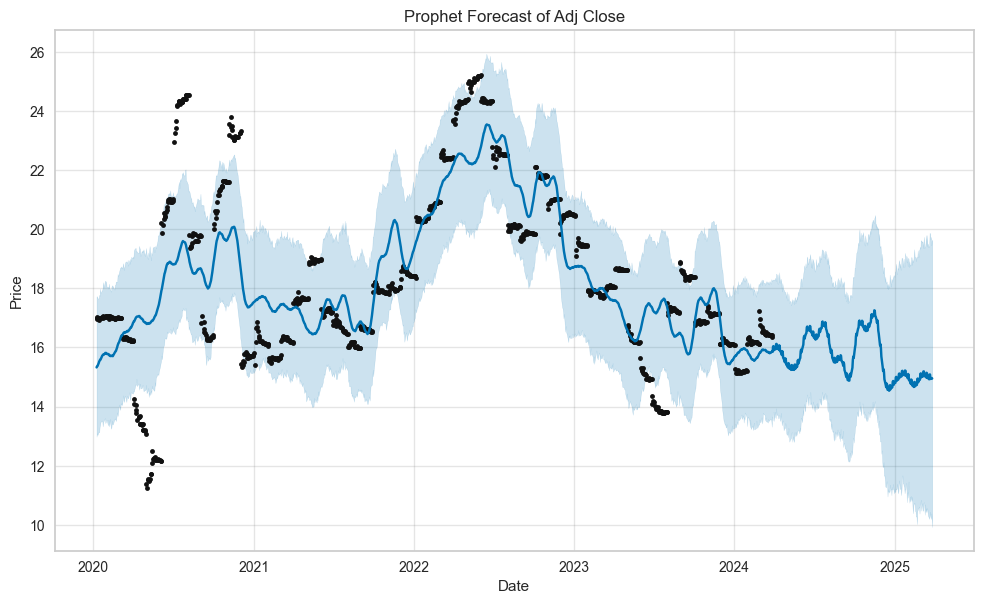

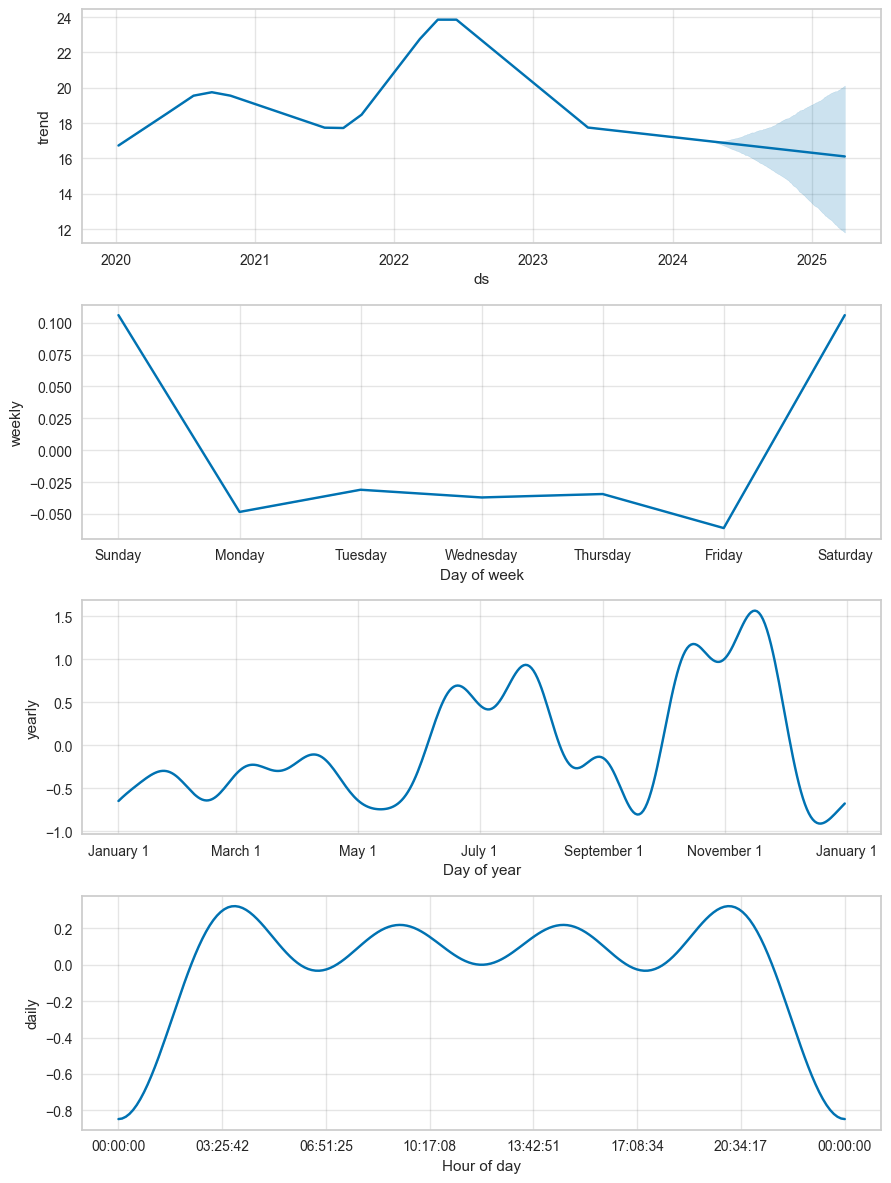

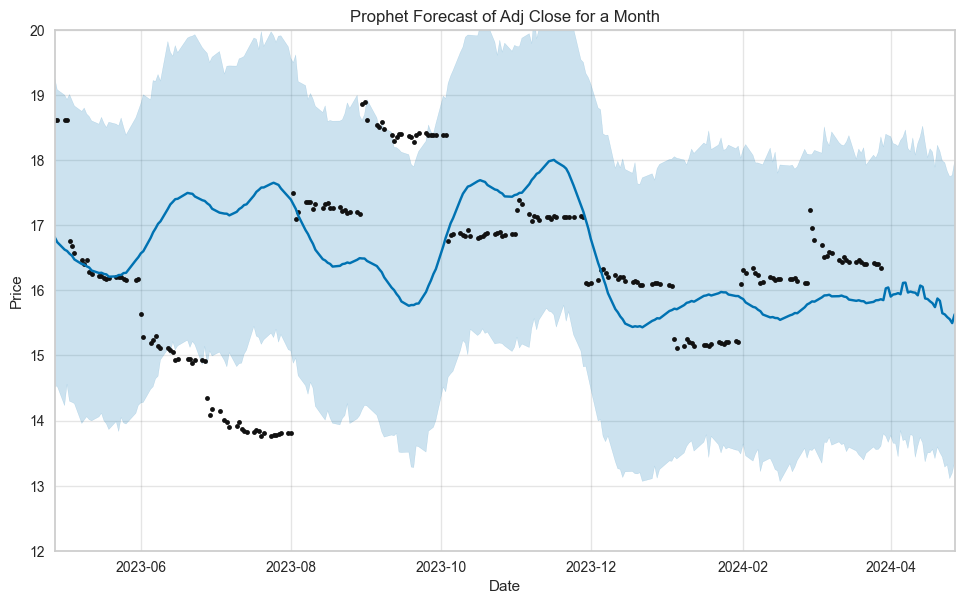

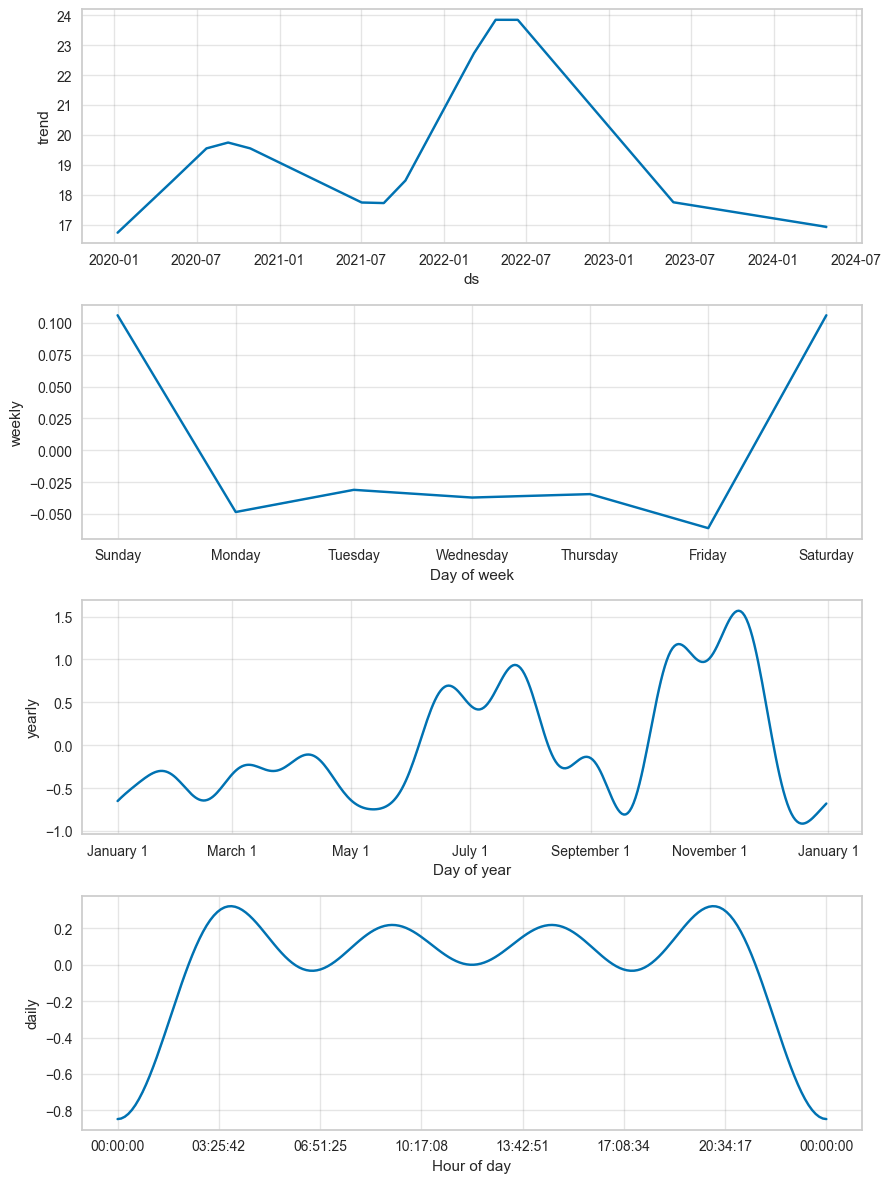

In [53]:
# Part 8: Forecasting Future Prices Using Prophet

# Preparing data for Prophet
prophet_df = data[['Adj Close']].reset_index()
prophet_df.columns = ['ds', 'y']

# Initializing and fitting the model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# Making future dataframe for predictions
future = model.make_future_dataframe(periods=365)  # Predicting the next year
forecast = model.predict(future)

# Plotting the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast of Adj Close')
plt.ylabel('Price')
plt.xlabel('Date')

# Plotting components
fig2 = model.plot_components(forecast)

# Making future dataframe for predictions

# Predicting for a month (30 days)
future_month = model.make_future_dataframe(periods=30)
forecast_month = model.predict(future_month)

# Plotting the forecast for a month
fig1_month = model.plot(forecast_month)
plt.title('Prophet Forecast of Adj Close for a Month')
plt.ylabel('Price')
plt.xlabel('Date')
plt.xlim(forecast_month['ds'].max() - pd.DateOffset(months=12), forecast_month['ds'].max())
plt.ylim(12,20)

# Plotting components
fig2 = model.plot_components(forecast_month)